## TOC:
* [Reading CVS files](#first-bullet)
* [Luminosity section](#second-bullet)
* [Trigger rate section](#third-bullet)
* [Model training section](#fourth-bullet)

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

Using TensorFlow backend.


In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [3]:
runs = [302634, 302635, 305814]
lumi_directory = data_directory = "./lumi"
rates_directory = "./rates"

# Reading cvs files <a class="anchor" id="first-bullet"></a>

Reading instantaneous luminosities from the cvs file produced with brilcalc and saving into a pandas dataframe:

In [4]:
df_rates = pd.DataFrame()
int_lumi2 = pd.DataFrame()
for run in runs:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"]), 
        ignore_index=True);    
    path = "%s/dt_rates_%s.csv" % (rates_directory, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True);
print("Done.")

Loading 302634
Loading 302635
Loading 305814
Done.


# Luminosity section <a class="anchor" id="second-bullet"></a>

Dropping useless rows inherited from the lumi CVS file:

In [5]:
int_lumi2["source"] = int_lumi2["source"].astype('str')
int_lumi2 = int_lumi2[int_lumi2["source"] != "nan"]
int_lumi2 = int_lumi2[int_lumi2["source"] != "source"]

Splitting run:fill field and the start and end lumi sections:

In [6]:
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['runfill'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

Converting run to integer and luminosities to float:

In [7]:
int_lumi2["run"] = int_lumi2["run"].astype('int')
int_lumi2["ls_start"] = int_lumi2["ls_start"].astype('int')
int_lumi2["ls_end"] = int_lumi2["ls_end"].astype('int')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

Converting time stamp to datetime:

In [8]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

Creating end time column from the start time:

In [9]:
int_lumi2["time_end"] = int_lumi2["time"]

Finding the runs and their start and end times:

In [10]:
boundaries = pd.DataFrame(columns=["run", "start", "end", "ls_start", "ls_end", "nLS"])
for i in runs:
    start = int_lumi2[int_lumi2["run"] == i]["time"]
    end = int_lumi2[int_lumi2["run"] == i]["time_end"]
    start_ls = int_lumi2[int_lumi2["run"] == i]["ls_start"]
    end_ls = int_lumi2[int_lumi2["run"] == i]["ls_end"]
    start =  start.reset_index(drop=True)
    end =  end.reset_index(drop=True)
    start_ls =  start_ls.reset_index(drop=True)
    end_ls =  end_ls.reset_index(drop=True)
    nLS = int(start_ls.iloc[-1]) - int(start_ls.iloc[0]) + 1
    print i, start.iloc[0], start.iloc[-1], start_ls.iloc[0], start_ls.iloc[-1], nLS
    boundaries = boundaries.append({"run": i, "start": start.iloc[0], "end": start.iloc[-1], 
                                   "ls_start": start_ls.iloc[0], "ls_end": start_ls.iloc[-1], "nLS": nLS}, 
                                   ignore_index = True)

302634 2017-09-12 01:07:57 2017-09-12 05:17:46 1 644 644
302635 2017-09-12 05:18:01 2017-09-12 13:42:19 1 1299 1299
305814 2017-10-28 05:44:33 2017-10-28 18:07:21 1 1913 1913


Reindexing the dataframe after removing some lines:

In [11]:
int_lumi2.index = pd.RangeIndex(len(int_lumi2.index))

In [12]:
print len(int_lumi2.index)

3813


Filling end time column:

In [13]:
def addTimeOffSet(startdate):
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

def shiftElement(df, boundaries):
    run0 = boundaries["run"].iloc[0]
    for index, rows in df.iterrows():
        run = rows["run"]
        nls = int(boundaries[boundaries["run"] == run]["nLS"])
        if(run > run0):
            nls = nls + index
        #print run, nls
        if((index < nls) & (index < len(int_lumi2.index)-1)):
            #print index, run, rows["time"], df["time"][index+1]
            df.loc[index, "time_end"] = df["time"][index+1]
        elif (index == len(int_lumi2.index)-1):
            #print index, run, rows["time"], addTimeOffSet(rows["time"])
            df.loc[index, "time_end"] = addTimeOffSet(rows["time"])
                    
shiftElement(int_lumi2, boundaries)

Plotting the instantaneous luminosities:

In [14]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Inst. Lumi. [E30 Hz/cm$^2$]")
    xfmt = mdates.DateFormatter('%y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

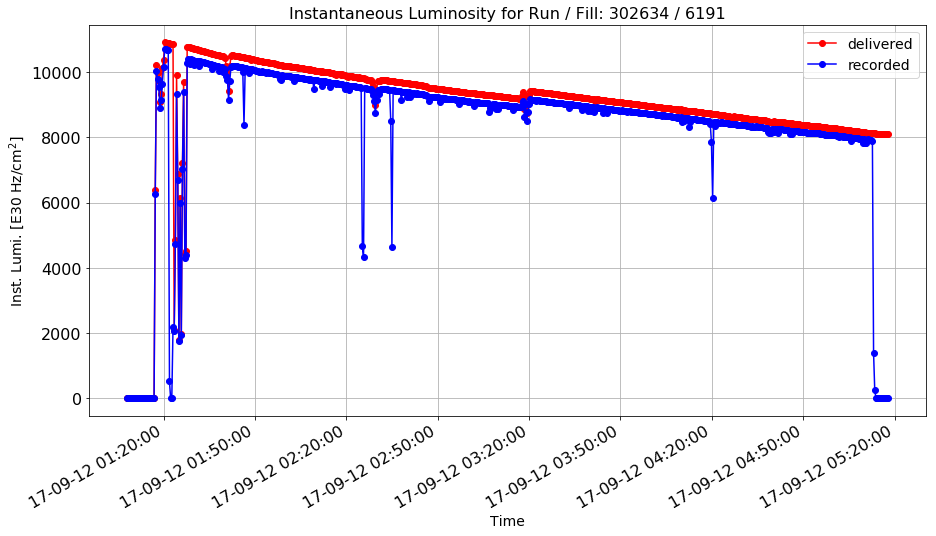

In [15]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 302634]["time"], 
               int_lumi2[int_lumi2["run"] == 302634]["delivered"], 
               int_lumi2[int_lumi2["run"] == 302634]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[0], int_lumi2["fill"].iloc[0])))

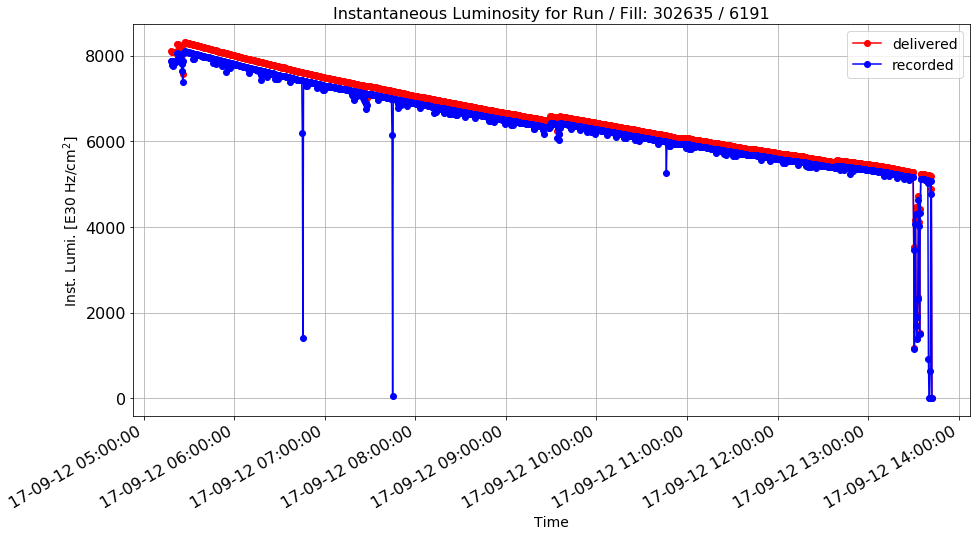

In [16]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 302635]["time"], 
               int_lumi2[int_lumi2["run"] == 302635]["delivered"], 
               int_lumi2[int_lumi2["run"] == 302635]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[1], int_lumi2["fill"].iloc[0])))

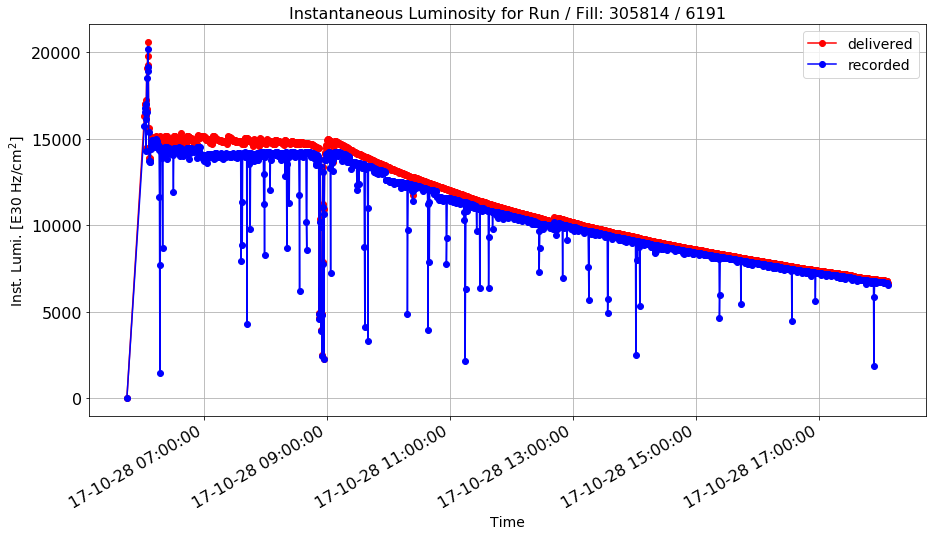

In [17]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 305814]["time"], 
               int_lumi2[int_lumi2["run"] == 305814]["delivered"], 
               int_lumi2[int_lumi2["run"] == 305814]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[2], int_lumi2["fill"].iloc[0])))

In [18]:
int_lumi2.to_csv("int_lumi_issues.csv", sep='\t')

# Trigger rate section <a class="anchor" id="third-bullet"></a>

Converting columns to proper data types:

In [19]:
df_rates["time"] = pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
#print df_rates["time"]

Splitting, converting and adding new columns:

In [20]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

In [21]:
df_rates["wheel"].replace(regex=True,inplace=True,to_replace=r'YB',value=r'')
df_rates["sector"].replace(regex=True,inplace=True,to_replace=r'S',value=r'')
df_rates["wheel"] = df_rates["wheel"].astype('int')
df_rates["sector"] = df_rates["sector"].astype('int')
df_rates["ls"] = -1
df_rates["lumi"] = -1.0
df_rates["score"] = -1
df_rates.to_csv("df_rates.csv", sep='\t')

Plotting the rate coming from one of the stations:

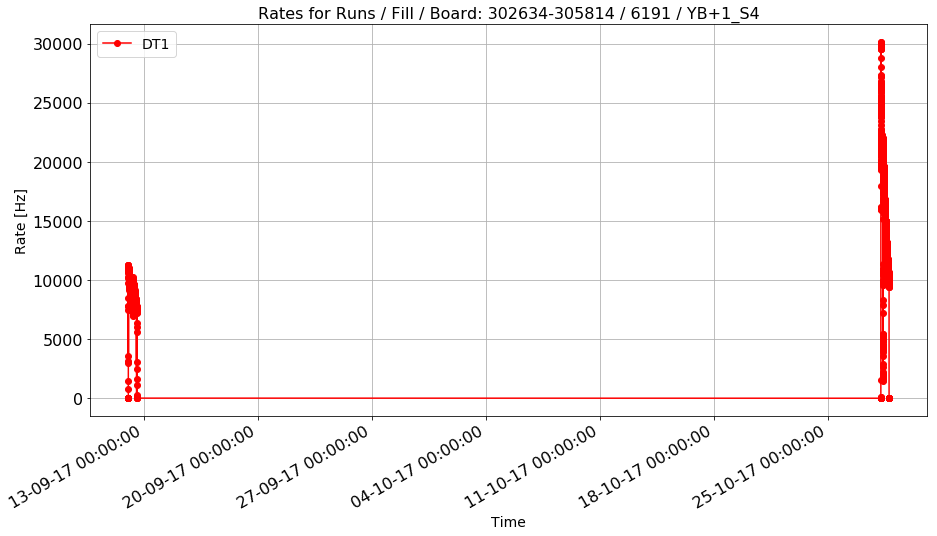

In [22]:
def plot_rate_vs_time(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

plot_rate_vs_time(df_rates, "time", "DT1", "YB+1_S4", "Rates for Runs / Fill / Board: %s / %s / %s" % 
                  (str(boundaries["run"].iloc[0])+"-"+str(boundaries["run"].iloc[2]), 
                   int_lumi2["fill"].iloc[2], "YB+1_S4"))

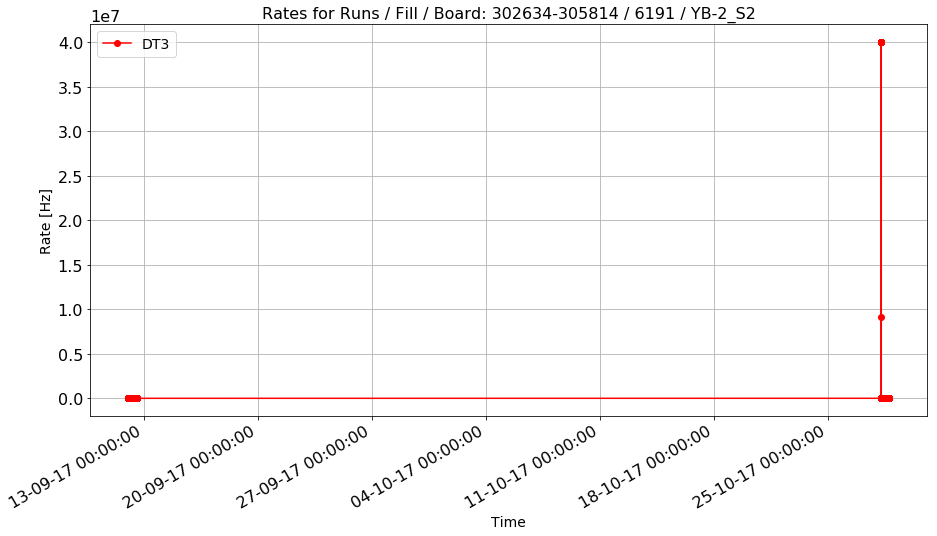

In [23]:
plot_rate_vs_time(df_rates, "time", "DT3", "YB-2_S2", "Rates for Runs / Fill / Board: %s / %s / %s" % 
                  (str(boundaries["run"].iloc[0])+"-"+str(boundaries["run"].iloc[2]), 
                   int_lumi2["fill"].iloc[2], "YB-2_S2"))

Associating a LS and an instantaneous luminosity to each rate:

In [24]:
#Just a backup copy
df_rates_backup = df_rates.copy()

In [25]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

Removing the measurements taken before and after the start and end time reported by the brilcalc output. All the 60 boards are measured at the same time. In order to speed-up the association, we take just one board, the first one. This reduces the dataframe and the time needed to go though it by a factor of 60.

In [26]:
time0 = boundaries["start"].iloc[0]
timeF = boundaries["end"].iloc[-1]
print time0, timeF
#print df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
df_rates = df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
rule = df_rates.duplicated(subset=["time"])
count = (rule == False).sum()
print "Duplicates:", rule.sum()
df_rates_noduplicates = df_rates[rule == False]
#print df_rates_noduplicates

2017-09-12 01:07:57 2017-10-28 18:07:21
Duplicates: 1014741


In [27]:
print len(df_rates_noduplicates)

17199


Assigning the LS and the inst. lumi. to the measurements for the selected board:

In [28]:
def assignLS(df1, df2, boundaries):
    temp = df1.copy()
    j = 1
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        time1 = row1["time"]
        #print index1, run1, time1
        ti = time1 - 2*pd.DateOffset(seconds=23)
        tf = time1 + 2*pd.DateOffset(seconds=23)
        indexes2 = df2[(df2.run == run1) & (df2.time > ti) & (df2.time < tf)].index
        #print indexes2
        for i in indexes2:
            if((time1 >= df2["time"].loc[i]) & (time1 < df2["time_end"].loc[i])):
                #print time1, df2["time"].loc[i], df2["time_end"].loc[i]
                if(j%1000 == 0): 
                    print j
                j = j + 1
                ls = df2["ls_start"].loc[i]
                lumi = df2["delivered"].loc[i]
                #print index1, run1, time1, ls, lumi
                temp.loc[index1, "ls"] = ls
                temp.loc[index1, "lumi"] = lumi
                break
    return temp

temp = assignLS(df_rates_noduplicates, int_lumi2, boundaries)
df_rates_noduplicates = temp

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


Removing the few cases not assigned and that are still at -1:

In [29]:
df_rates_noduplicates = df_rates_noduplicates[df_rates_noduplicates["ls"] > 0]
print len(df_rates_noduplicates)

16829


Save in a csv file:

In [30]:
df_rates.to_csv("df_rates_issues.csv", sep='\t')
df_rates_noduplicates.to_csv("df_rates_nodup_issues.csv", sep='\t')

In [31]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

Assign the LS and the inst. lumi. to all the 60 boards for each time:

In [32]:
def assignLS_ext(df1, df2):
    temp = df1.copy()
    indexes = []
    for index in df2.index:
        if index%10000 == 0:
            print index
        time = df2["time"].loc[index]
        ls = df2["ls"].loc[index]
        lumi = df2["lumi"].loc[index]
        des = (temp["time"] == time)
        indexes = temp[des].index
        #print time, ls, indexes
        temp.loc[des, "ls"] = ls
        temp.loc[des, "lumi"] = lumi
    return temp
    
temp = assignLS_ext(df_rates, df_rates_noduplicates)

30000
60000
90000
120000
150000
180000
210000
240000
270000
300000
330000
360000
390000
420000
450000
480000
510000
540000
570000
600000
630000
660000
690000
720000
750000
780000
810000
840000
870000
900000
930000
960000
990000
1020000


Save another backup copy:

In [50]:
df_rates = temp.copy()
#print df_rates[df_rates.ls <= 0]

Removing measurements without LS assignment:

In [51]:
df_rates_backup = df_rates.copy()
df_rates = df_rates[df_rates.ls > 0]
#print df_rates["ls"]

In [52]:
#print df_rates[df_rates.ls <= 0]
df_rates.to_csv("df_rates_issues.csv", sep='\t')

Averaging the rates associated to the same LS:

In [53]:
df_boards = df_rates.copy()
df_boards = df_boards.groupby(['board']).size().reset_index(name='counts')
print len(df_boards)
#print df_boards

60


Too slow to use all the measurements. Averaging over 10 LS:

In [54]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

In [55]:
def assignGroup(data, div = 1):
    res = int(data/div)
    #print data, res
    return res

df_rates["group"] = df_rates["ls"]
df_rates["group"] = df_rates["group"].apply(assignGroup)

In [56]:
#print df_rates["group"]

In [57]:
temp1 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["ls", "lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].mean().reset_index()

temp2 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].std().reset_index()

temp3 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].size().reset_index(name='counts')

temp2 = temp2.rename(index=str, columns={"lumi": "errLumi", "RPC1": "errRPC1", "RPC2": "errRPC2",\
                                         "RPC3": "errRPC3", "RPC4": "errRPC4", "DT1": "errDT1",\
                                         "DT2": "errDT2", "DT3": "errDT3", "DT4": "errDT4", "DT5": "errDT5"})

cols_to_use2 = temp2.columns.difference(temp1.columns)
cols_to_use3 = temp3.columns.difference(temp1.columns)

temp2 = temp2[cols_to_use2]
temp3 = temp3[cols_to_use3]

#print temp1.iloc[100]
#print temp2.iloc[100]
#print temp3.iloc[100]

temp1.reset_index(drop=True, inplace=True)
temp2.reset_index(drop=True, inplace=True)
temp3.reset_index(drop=True, inplace=True)

df_rates = pd.concat([temp1, temp2, temp3], axis = 1)

Calculating the errors on the mean values calculated in the previous step:

In [58]:
import math
def applySqrt(data):
    return math.sqrt(data)

df_rates["counts"] = df_rates["counts"].apply(applySqrt)

for i in list(df_rates):
    if "err" in i:
        #print i
        df_rates[i] = df_rates[i]/df_rates["counts"]

Check for null or NaN values:

In [59]:
print df_rates.isnull().values.any()
null_columns=df_rates.columns[df_rates.isnull().any()]
print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())
df_rates = df_rates.fillna(0)
print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())

True
   errDT1  errDT2  errDT3  errDT4  errDT5  errLumi  errRPC1  errRPC2  errRPC3  \
0     NaN     NaN     NaN     NaN     NaN      NaN      NaN      NaN      NaN   
1     NaN     NaN     NaN     NaN     NaN      NaN      NaN      NaN      NaN   
2     NaN     NaN     NaN     NaN     NaN      NaN      NaN      NaN      NaN   
3     NaN     NaN     NaN     NaN     NaN      NaN      NaN      NaN      NaN   
4     NaN     NaN     NaN     NaN     NaN      NaN      NaN      NaN      NaN   

   errRPC4  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
Empty DataFrame
Columns: [errDT1, errDT2, errDT3, errDT4, errDT5, errLumi, errRPC1, errRPC2, errRPC3, errRPC4]
Index: []


In [60]:
#Another backup
#df_rates_backup = df_rates.copy()
df_rates.to_csv("df_rates_issues.csv", sep='\t')

In [61]:
#Restore backup
#df_rates = df_rates_backup.copy()

In [62]:
print len(df_rates)

196080


Uncomment to check just one case:

In [63]:
#for index, row in df_rates.iterrows():
    #if row["board"] == "YB0_S1":
        #print "Index:", index,", Run:", row["run"],", Board: ",row["board"],",\
        #LS: ",row["ls"],", Rate: ",row["DT1"],", Error: ",row["errDT1"]

Plotting the result:

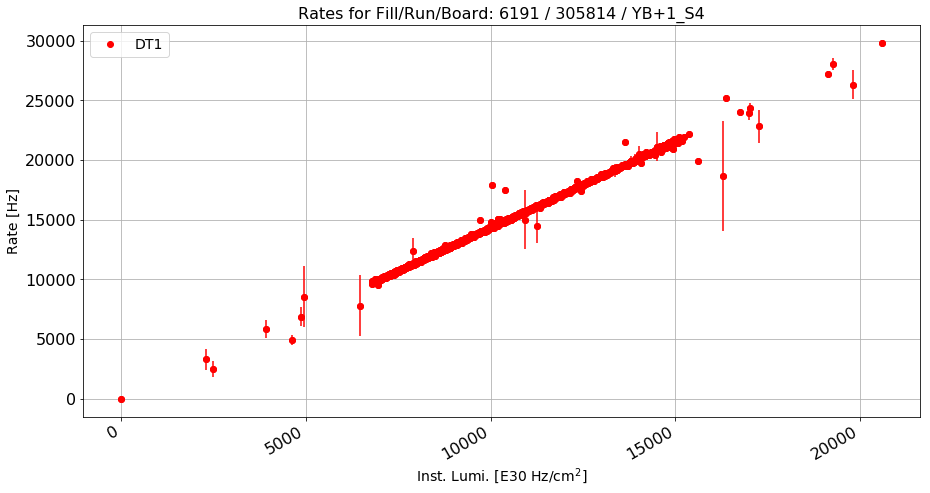

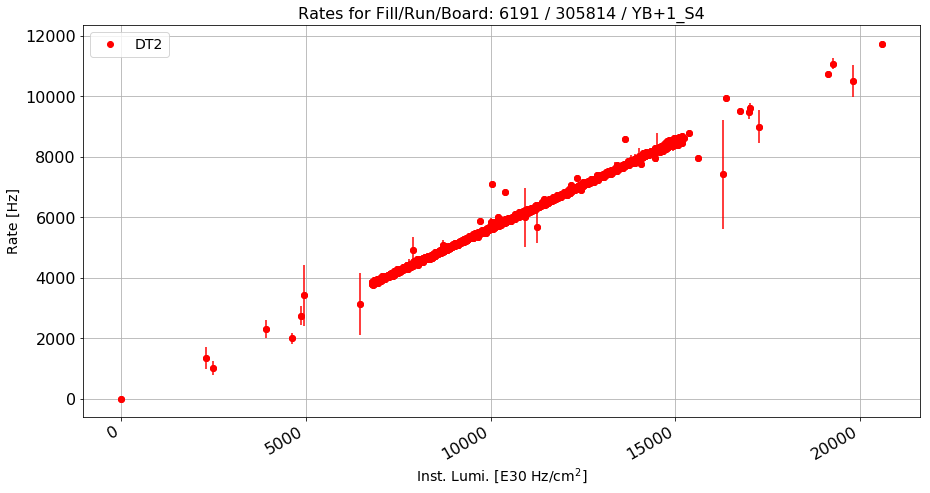

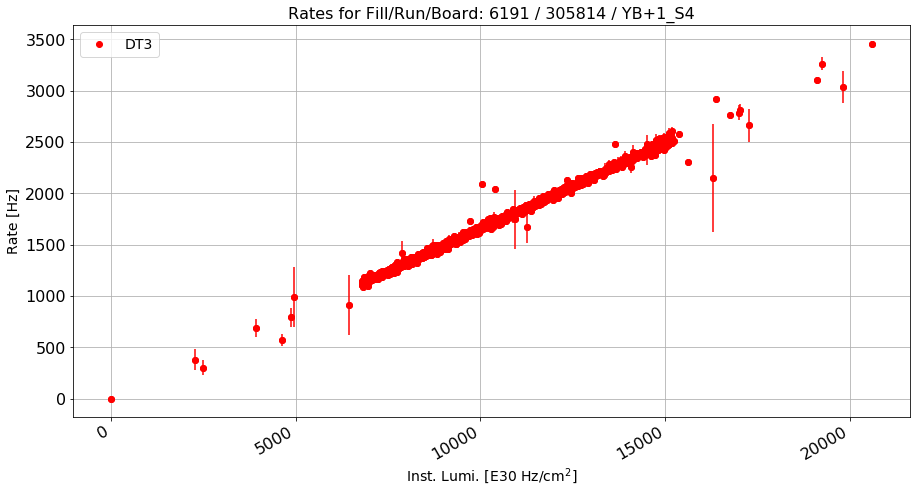

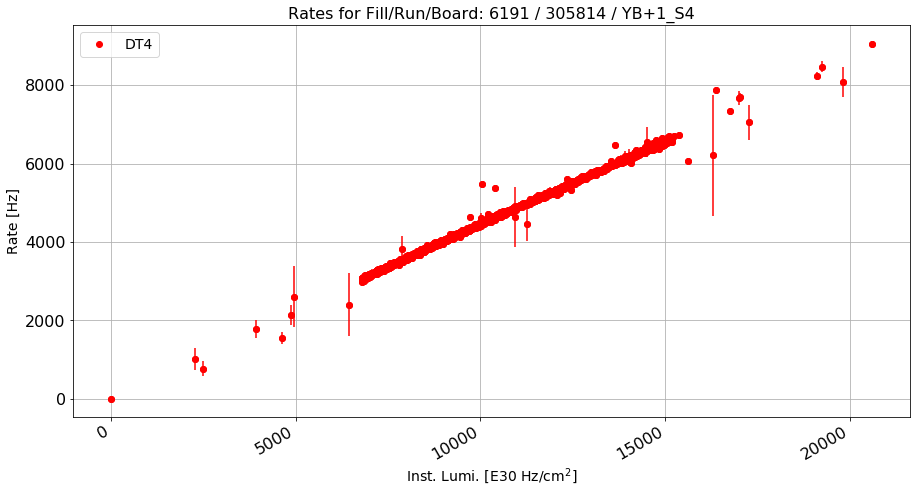

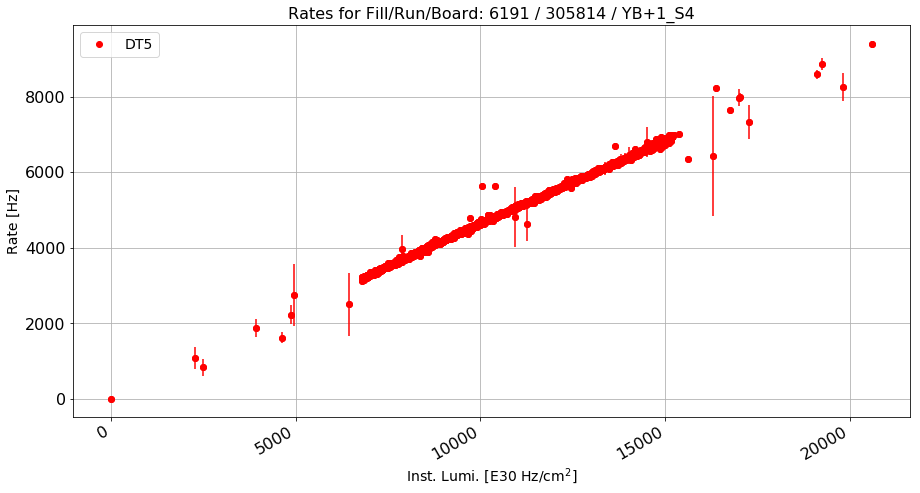

In [68]:
def plot_rate_vs_ls(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt, log):
    df_temp = df.copy()
    rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run))
    df_temp = df_temp[rule]
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    if log:
        ax.set_yscale('log')
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], opt)
    plt.legend(loc="best")
    plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    plt.title(title)
    plt.show();

title = "Rates for Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "+str(boundaries["run"].iloc[2])+" / YB+1_S4"

plot_rate_vs_ls(df_rates, 305814, "lumi", "DT1", "YB+1_S4", 0, "errDT1", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro", False)
plot_rate_vs_ls(df_rates, 305814, "lumi", "DT2", "YB+1_S4", 0, "errDT2", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro", False)
plot_rate_vs_ls(df_rates, 305814, "lumi", "DT3", "YB+1_S4", 0, "errDT3", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro", False)
plot_rate_vs_ls(df_rates, 305814, "lumi", "DT4", "YB+1_S4", 0, "errDT4", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro", False)
plot_rate_vs_ls(df_rates, 305814, "lumi", "DT5", "YB+1_S4", 0, "errDT5", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro", False)

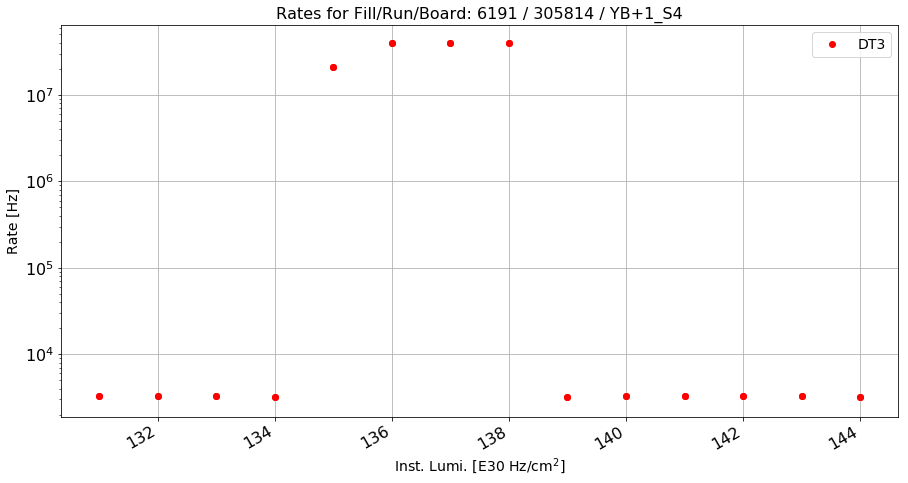

In [75]:
plot_rate_vs_ls(df_rates[(df_rates["ls"] > 130) & (df_rates["ls"] < 145)], 305814, "ls", "DT3", "YB-2_S2", 0,\
                "errDT1", "Inst. Lumi. [E30 Hz/cm$^2$]", "Rate [Hz]", title, "ro", True)

Create a new dataframe with the input features already organized in a numpy array:

In [157]:
print len(df_rates)
algos = ['RPC1', 'RPC2', 'RPC3', 'RPC4', 'DT1', 'DT2', 'DT3', 'DT4', 'DT5']
df_rates_new = pd.DataFrame(columns=['run', 'group', 'board', 'wheel', 'sector', 'ls',\
                                     'lumi', 'errLumi', 'rate', 'err', 'system', 'station'])

for i in algos:
    list_a = ['run', 'group', 'board', 'wheel', 'sector', 'ls', 'lumi', 'errLumi', i, 'err'+i,]
    temp = df_rates.copy()
    temp = temp[list_a]
    temp["system"] = -1
    temp["station"] = -1
    j = i
    if (i.find("RPC") != -1):
        temp["system"] = 1
        num = i.replace("RPC", "")
        temp["station"] = int(num)
    else:
        temp["system"] = 2
        num = i.replace("DT", "")
        temp["station"] = int(num)
    temp = temp.rename(columns={j: 'rate', 'err'+j: 'err'})
    #print temp.columns
    df_rates_new = pd.concat([df_rates_new, temp], ignore_index=True)

print len(df_rates_new)

196080
1764720


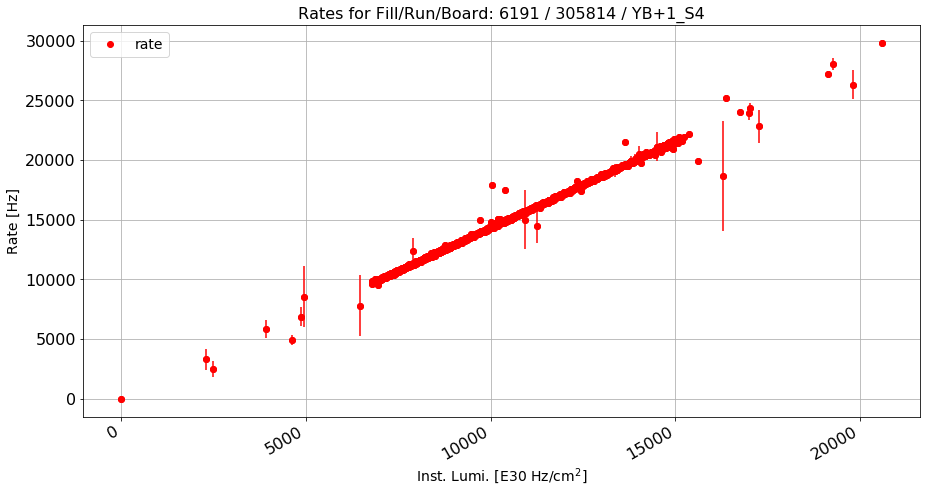

In [150]:
plot_rate_vs_ls(df_rates_new[(df_rates_new["system"] == 2) & (df_rates_new["station"] == 1)], 305814,\
                "lumi", "rate", "YB+1_S4", 0, "err", "Inst. Lumi. [E30 Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro", False)

In [229]:
df_rates_new["CS"] = -1
df_rates_new["errCS"] = -1
df_rates_new["content"] = -1

df_rates_new["CS"] = df_rates_new["lumi"]/df_rates_new["rate"]
print "Number of NaN's in CS before:"
print len(df_rates_new["CS"][df_rates_new["CS"].isnull() == True])
print "Number of Inf's in CS before:"
print len(df_rates_new["CS"][np.isinf(df_rates_new["CS"])])

df_rates_new["CS"] = df_rates_new["CS"].replace([np.inf, -np.inf], np.nan)
df_rates_new["CS"] = df_rates_new["CS"].fillna(-1)
print "Number of NaN's in CS after:"
print len(df_rates_new["CS"][df_rates_new["CS"].isnull() == True])
print "Number of Inf's in CS after:"
print len(df_rates_new["CS"][np.isinf(df_rates_new["CS"])])

df_rates_new["errCS"] = (1/df_rates_new["rate"])*np.sqrt(df_rates_new["errLumi"]*df_rates_new["errLumi"] +\
                        df_rates_new["CS"]*df_rates_new["CS"]*df_rates_new["err"]*df_rates_new["err"])

print "Number of NaN's in errCS before:"
print len(df_rates_new["errCS"][df_rates_new["errCS"].isnull() == True])
df_rates_new["errCS"] = df_rates_new["errCS"].fillna(-1)
print "Number of NaN's in errCS after:"
print len(df_rates_new["errCS"][df_rates_new["errCS"].isnull() == True])

Number of NaN's in CS before:
6
Number of Inf's in CS before:
35539
Number of NaN's in CS after:
0
Number of Inf's in CS after:
0
Number of NaN's in errCS before:
35545
Number of NaN's in errCS after:
0


In [231]:
print df_rates_new.columns

Index([u'run', u'group', u'board', u'wheel', u'sector', u'ls', u'lumi',
       u'errLumi', u'rate', u'err', u'system', u'station', u'CS', u'errCS',
       u'content', u'score'],
      dtype='object')


In [254]:
array = df_rates_new.as_matrix(columns=['system', 'wheel', 'sector', 'station',\
                                        'lumi', 'errLumi', 'rate', 'err',\
                                        'CS', 'errCS'])
array = np.reshape(array, (10, 1, -1))
print array
print pd.DataFrame(array, )

[[[1 1 1 ..., 416.41688497941476 0.05574368152050803 0.00016253972888155007]]

 [[1 2 1 ..., 1286.4285663022051 0.07856664994931763 0.0008422621235286941]]

 [[1 -1 1 ..., 61.383296513865176 1.4369513079513085 0.01142253408598311]]

 ..., 
 [[2 -1 1 ..., 0.0 17.565489411764705 0.0]]

 [[2 -2 1 ..., 0.0 4.300790159189581 0.0]]

 [[2 0 1 ..., 0.0 0.00016976442924411072 0.0]]]


ValueError: Must pass 2-d input

In [235]:
df_rates_new["content"] = array
df_rates_new["score"] = -1

In [236]:
print df_rates_new["content"]

0          1
1          1
2          1
3          1
4          1
5          1
6          1
7          1
8          1
9          1
10         1
11         1
12         1
13         1
14         1
15         1
16         1
17         1
18         1
19         1
20         1
21         1
22         1
23         1
24         1
25         1
26         1
27         1
28         1
29         1
          ..
1764690    2
1764691    2
1764692    2
1764693    2
1764694    2
1764695    2
1764696    2
1764697    2
1764698    2
1764699    2
1764700    2
1764701    2
1764702    2
1764703    2
1764704    2
1764705    2
1764706    2
1764707    2
1764708    2
1764709    2
1764710    2
1764711    2
1764712    2
1764713    2
1764714    2
1764715    2
1764716    2
1764717    2
1764718    2
1764719    2
Name: content, Length: 1764720, dtype: object


# Model inference section <a class="anchor" id="fourth-bullet"></a>

Creating train and test samples:

In [142]:
df_rates_new = df_rates_new[df_rates_new["system"] == 2]
normalies = df_rates_new.copy()
anomalies = df_rates_new.copy()

In [143]:
print len(normalies), len(anomalies)

980400 980400


In [144]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3) 
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
nan
Anomalous chimney:
nan


In [ ]:
def assignScore(df, score):
    temp = df.copy()
    rule = (temp["wheel"] == 1) & (temp["sector"] == 4) & (temp["station"] == 3)
    indexes = temp[rule].index
    #print indexes
    for i in indexes:
        temp.loc[i, "score"] = score
    return temp

temp = assignScore(anomalies, 1)
anomalies = temp

In [ ]:
def deduceLS(data):
    return data*10+5
anomalies["averageLS"] = anomalies["group"].apply(deduceLS)
print anomalies.columns

During run 305815, W-2_S2_MB3 showed some high rate for short periods (?). The run is good except for that chamber:

In [ ]:
def assignScore3(df, score, run, ls_in, ls_end):
    temp = df.copy()
    rule = (temp["station"] == 3) & (temp["sector"] == 2) & (temp["wheel"] == -2)
    rule = rule & (temp["run"] == run)
    if ((ls_in != -1) & (ls_end != -1)):
        rule = rule & (temp["averageLS"] >= ls_in) & (temp["averageLS"] <= ls_end)
    elif (ls_in != -1):
        rule = rule & (temp["averageLS"] >= ls_in)
    elif (ls_end != -1):
        rule = rule & (temp["averageLS"] <= ls_end)

    indexes = temp[rule].index
    for w in indexes:
        temp.loc[w, "score"] = score
    return temp

In [ ]:
#temp = assignScore3(anomalies, 1, 305814, -1, -1)
#rule = (temp["run"] == 305814) & (temp["station"] != 3) & (temp["sector"] != 2) & (temp["wheel"] != -2)
#print temp[rule]["score"]
#anomalies = temp

During runs 302634(All LS's) and 302635(LS <= 404) one layer per station did not reach the correct HV, except for: MB1, MB4 in sectors 3, 4, 5 in wheels 2, -2, 0: 

In [ ]:
def assignScore2(df, score, run, ls_in, ls_end):
    temp = df.copy()
    rule = (temp["run"] == run)
    if ((ls_in != -1) & (ls_end != -1)):
        rule = rule & (temp["averageLS"] >= ls_in) & (temp["averageLS"] <= ls_end)
    elif (ls_in != -1):
        rule = rule & (temp["averageLS"] >= ls_in)
    elif (ls_end != -1):
        rule = rule & (temp["averageLS"] <= ls_end)
    indexes = temp[rule].index
    for w in indexes:
        temp.loc[w, "score"] = score

    #Correct score for the chambers with normal HV
    for i in [1, 4, 5]:
        for j in [3, 4, 5]:
            for k in [-2, 0, 2]:
                rule = (temp["run"] == run) &(temp["station"] == i) & (temp["sector"] == j) & (temp["wheel"] == k)
                indexes = temp[rule].index
                for w in indexes:
                    temp.loc[w, "score"] = -1
    return temp
                
temp = assignScore2(anomalies, 1, 302634, -1, -1)
temp = assignScore2(anomalies, 1, 302635, 1, 404)

In [ ]:
#rule = ((temp["station"] == 1) & (temp["sector"] == 3) & (temp["wheel"] == 2))
#print temp[rule]["score"]
anomalies = temp

In [ ]:
#Scale the data
def scale_data(data):
    """Scales layer data using MaxAbsScaler"""
    # Need to reshape since scaler works per column
    data = data.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(data)
    return scaler.transform(data).reshape(1, -1)

anomalies["content"] = anomalies["content"].apply(np.array)
anomalies["content_scaled"] = anomalies["content"].apply(scale_data)

normalies["content"] = normalies["content"].apply(np.array)
normalies["content_scaled"] = normalies["content"].apply(scale_data)

In [ ]:
#print anomalies["content_scaled"]
#print normalies["content_scaled"]

In [ ]:
layers_test = anomalies

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
K.set_session(sess)

In [ ]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0]) #Normaly
    return np.asarray([0, 1]) #Anomaly

def nn_generate_input():  
    return np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 10)

test_x = nn_generate_input()

Making an inference using the model and the test sample:

In [ ]:
ann_model_1 = load_model("./model_keras/ann_1.h5")
ann_model_2 = load_model("./model_keras/ann_2.h5")
ann_model_3 = load_model("./model_keras/ann_3.h5")
ann_model_4 = load_model("./model_keras/ann_4.h5")
cae_model = load_model("./model_keras/cae_best.h5")

In [ ]:
layers_test["ann_score_1"] = ann_model_1.predict(np.array(test_x))[:, 1]
layers_test["ann_score_2"] = ann_model_2.predict(np.array(test_x))[:, 1]
layers_test["ann_score_3"] = ann_model_3.predict(np.array(test_x))[:, 1]
layers_test["ann_score_4"] = ann_model_4.predict(np.array(test_x))[:, 1]
layers_test["cae_score"] = np.sum(abs(test_x - cae_model.predict(np.array(test_x))), axis=1)

In [ ]:
#print layers_test["ann_score"]
#print layers_test["score"]

In [ ]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    y_true = 2*(y_true > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity
    
print "DNN:"
specificity_ann, sensitivity_ann = benchmark(layers_test["score"], layers_test["ann_score_4"], 0.9)
print "AE:"
specificity_cae, sensitivity_cae = benchmark(layers_test["score"], layers_test["cae_score"], 0.035)

In [ ]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])
        #plt.xlim(0, 0.2)
        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o',
                 label="DNN working point")
    plt.title("ROC")
    plt.legend(loc='best')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.show();

In [ ]:
get_roc_curve(layers_test, 
              [
               ("AE", "cae_score"),
               ("SNN", "ann_score_1"),
               ("DNN (2 layers)", "ann_score_2"),
               ("DNN (3 layers)", "ann_score_3"),
               ("DNN (4 layers)", "ann_score_4"),
               ], (specificity_ann, sensitivity_ann))

In [ ]:
# Distribution of scores:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(0, 1, 100)
plt.hist(layers_test[layers_test["score"] < 0]["ann_score_4"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_test[layers_test["score"] > 0]["ann_score_4"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: DNN (4 layers)")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(0, 0.125, 100)
plt.hist(layers_test[layers_test["score"] < 0]["cae_score"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_test[layers_test["score"] > 0]["cae_score"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: AE")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
threshold = 0.9
y_pred = 2*(layers_test["ann_score_4"] > threshold)-1
layers_test["score"] = 2*(layers_test["score"] > threshold)-1

cnf_matrix = confusion_matrix(layers_test["score"], y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix DNN, with normalization')

In [ ]:
threshold = 0.035
y_pred = 2*(layers_test["cae_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix AE, with normalization')

In [ ]:
print "Number of FPs for the DNN:", len(layers_test[(layers_test["score"] == -1) & (layers_test["ann_score_4"] > 0.9)])

In [ ]:
print "Number of FPs for the AE:", len(layers_test[(layers_test["score"] == -1) & (layers_test["cae_score"] > 0.035)])

In [ ]:
layers_test["name"] = ("W" + layers_test["wheel"].astype(str) + "_S" + layers_test["sector"].astype(str) +\
       "_St" + layers_test["station"].astype(str))

Where are the FPs located?

In [ ]:
def count_fp(df, dis_nn, th, filt):
    df_temp = df[(layers_test["score"] == -1) & (layers_test[dis_nn] > th)].copy()
    df_temp = df_temp.groupby(['run', 'wheel', 'sector', 'station', 'name']).size().reset_index(name='counts')
    if filt:
        df_temp = df_temp[df_temp["counts"] > 1]
    #print df_temp
    return len(df_temp), df_temp

num_fp_ann, fp_ann = count_fp(layers_test, "ann_score_4", 0.5, False)
num_fp_cae, fp_cae = count_fp(layers_test, "cae_score", 0.035, True)

print "Number of chambers with false positives DNN:", num_fp_ann
print "Number of chambers with false positives AE:", num_fp_cae
fp_cae.set_index("name",drop=True,inplace=True)
fp_ann.set_index("name",drop=True,inplace=True)

In [ ]:
fp_ann["counts"].plot(kind='bar', title ="False positives DNN", legend=True, fontsize=12)

In [ ]:
fp_cae["counts"].plot(kind='bar', title ="False positives AE", legend=True, fontsize=12)

In [ ]:
def get_matrix(df):
    x = np.zeros((5,12),dtype=int)
    for i in range(len(df)):
        a = int(5-df["station"].iloc[i])
        b = int(df["sector"].iloc[i]-1)
        x[a,b] = x[a,b] + 1
    return x

In [ ]:
def plot_scatter(df, run, wheel, ls_min, ls_max):
    run_s = "All"
    wheel_s = "All"
    ls_s = "All"
    temp = df.copy()
    if wheel != -3:
        temp = temp[(temp["wheel"] == wheel)]
        wheel_s = str(wheel)
    if run != -1:
        temp = temp[(temp["run"] == run)]
        run_s = str(run)
    if ((ls_min != -1) & (ls_max == -1)):
        temp = temp[(temp["averageLS"] >= ls_min)]
        ls_s = "> "+str(ls_min)
    elif ((ls_min == -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] <= ls_max)]
        ls_s = "< "+str(ls_max)
    elif ((ls_min != -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] >= ls_min) & (temp["averageLS"] <= ls_max)]
        ls_s = " ["+str(ls_min)+", "+str(ls_max)+"]"
    mat = get_matrix(temp)
    print mat
    print mat.sum()

    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1", "2", "3", "4", "5"])
    ax.set_yticks([4, 3, 2, 1, 0])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    plt.xlabel("Sector")
    plt.ylabel("Station")
    
    im = ax.imshow(mat, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    for i in range(0,5):
        for j in range(0,12):
            text = ax.text(j, i, mat[i, j],\
            ha="center", va="center", color="w")
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(mat)), np.max(np.nan_to_num(mat))])
    title = "Run: "+run_s+", Wheel: "+wheel_s+", LS: "+ls_s
    plt.title(title, loc="right")   
    plt.show()

In [ ]:
th = 0.035
dis_nn = "cae_score"
rule = (layers_test["score"] == -1) & (layers_test[dis_nn] > th)

plot_scatter(layers_test[rule], 305814, -2, -1, -1)
plot_scatter(layers_test[rule], 302634, -3, -1, -1)

plot_scatter(layers_test[rule], -1, -2, -1, -1)
plot_scatter(layers_test[rule], -1, -1, -1, -1)
plot_scatter(layers_test[rule], -1, 0, -1, -1)
plot_scatter(layers_test[rule], -1, +1, -1, -1)
plot_scatter(layers_test[rule], -1, +2, -1, -1)

Where are the FPs located in time?

In [ ]:
def plotFpVsLs(run, wheel, sector, station, title, df, algo, threshold, log, bound):
    fig, ax = plt.subplots()
    if log:
        ax.set_yscale('log')
    bins = np.linspace(0, bound, int(bound/10)+10)
    plt.hist(df[(df["score"] == -1) & (df[algo] > threshold)
                         #& (df["wheel"] == 2) &\
                         #& (df["sector"] == 4) &\
                         #& (df["station"] == 2) &\
                         & (df["run"] == run)\
                        ]["averageLS"],
             bins=bins, label="False positives")
    plt.title(title+str(run))
    plt.legend(loc='best')
    plt.ylabel('Frequency')
    plt.xlabel('Average LS')
    #plt.plot([bound, bound], [0, 100], color='r', linestyle='--', linewidth=2)
    plt.show()

In [ ]:
threshold = 0.035
plotFpVsLs(302634, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score", threshold, True,\
           boundaries[boundaries["run"] == 302634]["ls_end"])
plotFpVsLs(302635, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score", threshold, True,\
           boundaries[boundaries["run"] == 302635]["ls_end"])
plotFpVsLs(305814, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score", threshold, True,\
           boundaries[boundaries["run"] == 305814]["ls_end"])

Trying KNeighborsClassifier classifier:

In [ ]:
from sklearn import neighbors
knclf = neighbors.KNeighborsClassifier(5, weights='distance')
knclf.fit(np.vstack(layers_train["content_scaled"].values),\
          -layers_train["score"].astype(int))

In [ ]:
layers_test["knn_score"] = -knclf.predict(np.vstack(layers_test["content_scaled"].values))

In [ ]:
threshold = 0.0
y_pred = 2*(layers_test["knn_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix KNN, with normalization')

Trying unsupervised algorithms:

In [ ]:
# fit the model
from sklearn.neighbors import LocalOutlierFactor
lofclf = LocalOutlierFactor(n_neighbors=5555)
layers_train["lof_score"] = -lofclf.fit_predict(np.vstack(layers_train["content_scaled"].values))

In [ ]:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(-2, +2, 100)
plt.hist(layers_train[layers_train["score"] < 0]["lof_score"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_train[layers_train["score"] > 0]["lof_score"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: LOF")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

In [ ]:
threshold = 0.0
y_pred = 2*(layers_train["lof_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_train["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix LOF, with normalization')

In [ ]:
layers_train["averageLS"] = layers_train["group"].apply(deduceLS)
threshold = 0.0
plotFsVsLs(306121, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 306121]["ls_end"])
plotFsVsLs(306122, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 306122]["ls_end"])
plotFsVsLs(306125, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 306125]["ls_end"])
plotFsVsLs(306126, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 306126]["ls_end"])